In [1]:
import gym
from gym import wrappers
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from collections import defaultdict
import itertools
import ast

In [304]:
class TicTacToe:
    def __init__(self):
        self.board = []
        self.previous_board = []
        self.moves = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]

    def reset(self):
      self.board = []
      for i in range(3):
          row = []
          for j in range(3):
              row.append(-1)
          self.board.append(row)
      return self.board

    def step(self, move, player):
      move = self.moves[move]
      row, col = move[0], move[1]
      if self.board[row][col] == -1:
        self.previous_board = copy.deepcopy(self.board)
        self.board[row][col] = player
        # done and this player won, +1 reward
        if self.done(player):
          return self.board, 1, True
        # done and its a draw, -1 reward
        elif self.is_board_filled():
          return self.board, -1, True
        # not done, 0 reward
        else: return self.board, 0, False
      #else: print(self.board, move)

    def done(self, player):
        win = None

        n = len(self.board)

        # checking rows
        for i in range(n):
            win = True
            for j in range(n):
                if self.board[i][j] != player:
                    win = False
                    break
            if win:
                return win

        # checking columns
        for i in range(n):
            win = True
            for j in range(n):
                if self.board[j][i] != player:
                    win = False
                    break
            if win:
                return win

        # checking diagonals
        win = True
        for i in range(n):
            if self.board[i][i] != player:
                win = False
                break
        if win:
            return win

        win = True
        for i in range(n):
            if self.board[i][n - 1 - i] != player:
                win = False
                break
        if win:
            return win
        return False

        for row in self.board:
            for item in row:
                if item == -1:
                    return False
        return True

    # we check if the other player has won (which means that this one lost)
    def player_lost(self, player):
      player = 1 if player == 0 else 1
      return self.done(player)

    def is_board_filled(self):
        for row in self.board:
            for item in row:
                if item == -1:
                    return False
        return True

    def get_possible_moves(self, state):
        moves = []
        for index in range(len(self.moves)):
          move = self.moves[index]
          if state[move[0]][move[1]] == -1:
            moves.append(self.moves.index(move))
        return moves
    
    def undo(self):
        self.board = self.previous_board

    def render(self):
        for row in self.board:
            for item in row:
                print(item, end=" ")
            print()

In [321]:
class N_Step_Q_Learning():
  def __init__(self, env, N, epsilon, learning_rate=0.9, discount_factor=0.95, initial_q_value=0.5):
        self.env = env
        self.player = 0
        self.Q = {}  # [string, np.ndarray]
        self.states = []
        self.actions = []
        self.rewards = []
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.initial_q_value = initial_q_value
        self.N = N
        super().__init__()

  """
    We get the q-values of all the actions given this state
    If the state is not in the Q-table, we initialize all the q-values as initial_q_value
  """
  def get_q_value(self, hashed_state):
      if hashed_state in self.Q:
        return self.Q[hashed_state]
      else: 
        q_values = np.full(9, self.initial_q_value)
        self.Q[hashed_state] = q_values
        return q_values

  """
    We get the action that has the best q-value
  """
  def get_action(self, state):
      q_values = self.get_q_value(str(state))

      posible_actions = self.env.get_possible_moves(state)
      best_possible_action = posible_actions[0]
      for action in posible_actions:
        if q_values[action] > best_possible_action:
          best_possible_action = action
      return best_possible_action

  """
    Randomly select an action from the list of possible actions, or get an action based on learned policy depending on our sample
    If the current state hasnt been visited before, we initialize the q-values for all actions as initial_q_value
  """
  def random_epsilon_greedy_policy(self, state):
    sample = random.random()
    if sample > self.epsilon:
      return self.get_action(state)
    else:
      actions = self.env.get_possible_moves(state)
      hashed_state = str(state)
      if hashed_state in self.Q:
        return actions[random.randrange(len(actions))]
      else: 
        q_values = np.full(9, self.initial_q_value)
        self.Q[hashed_state] = q_values
        return actions[random.randrange(len(actions))]

  # https://rl-book.com/learn/value_methods/n_step/
  # https://medium.com/zero-equals-false/n-step-td-method-157d3875b9cb
  def train(self, state):
    t = 0           # current timestep
    t_update = 0    # timestep at which we update the q-value
    while True:
      t += 1
      # policy takes an action first
      action = self.random_epsilon_greedy_policy(state)
      self.states.append(str(state))
      self.actions.append(action)
      # we observe the next state and reward
      next_state, reward, done = self.env.step(action, self.player)
      state = next_state
      self.player = 1

      # this player has not won yet, so expert also takes an action
      if not done:
        action = self.expert_policy(state, self.player)
        # we observe the next state and reward again
        next_state, reward, done = self.env.step(action, self.player)
        state = next_state
        self.player = 0
      
      # the player must have lost the game, we penalize it
      if done and self.player == 0:
        reward = -2
      
      # we can finally save the reward as well
      self.rewards.append(reward)

      # we reached the number of steps needed to update our policy
      if t >= self.N:
          # we compute the discounted reward for n steps
          G = 0
          for i in range(t_update, t):
            G += self.discount_factor**(i - t_update - 1) * self.rewards[i]

          # we have yet to visit the next state, so we initialize all its q-values as initial_q_value
          if not str(next_state) in self.Q:
            self.Q[str(next_state)] = np.full(9, self.initial_q_value)
          # we compute the estimated value after n
          G += self.discount_factor**self.N * self.Q[str(next_state)]

          # improve policy according to the bellman update
          self.Q[self.states[t_update]][self.actions[t_update]] += self.learning_rate * (np.max(G) - self.Q[self.states[t_update]][self.actions[t_update]]) 

          t_update += 1

      if done:
        #self.env.render()
        #print()
        self.reset()
        return reward
  
  def reset(self):
    self.player = 0
    self.states = []
    self.actions = []
    self.rewards = []
  
  """
    We use the minmax algorithm to get the score of each action and return the action with max score
  """
  def expert_policy(self, state, player):
    bestScore = -math.inf
    best_action = None
    env_clone = copy.deepcopy(self.env)
    for action in env_clone.get_possible_moves(state):
        env_clone.step(action, player)
        score = self.minimax(False, player, env_clone)
        env_clone.undo()
        if (score > bestScore):
            bestScore = score
            best_action = action
    return best_action

  """
    In short this algorithm makes a search tree for the given state and returns a score
  """
  def minimax(self, isMaxTurn, player, env_copy):
      state = env_copy.board
      # draw
      if (env_copy.is_board_filled()):
          return -1
      # this player won
      elif (env_copy.done(player)):
          return 1
      # this player lost
      elif (env_copy.player_lost(player)):
          print("lost")
          return -2

      scores = []
      for action in env_copy.get_possible_moves(state):
          env_copy.step(action, player)
          scores.append(self.minimax(not isMaxTurn, player, env_copy))
          env_copy.undo()

      return max(scores) if isMaxTurn else min(scores)

In [377]:
env = TicTacToe()
agent = N_Step_Q_Learning(env, N=3, epsilon=0.1, initial_q_value=0.5)

Text(0, 0.5, 'rewards')

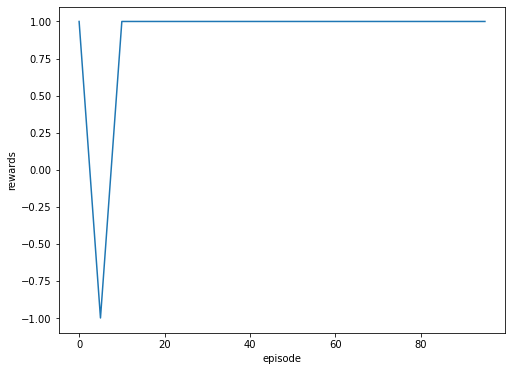

In [385]:
EPISODES = 100

rew = []

for e in range(EPISODES):
  state = env.reset()
  reward = agent.train(state)
  if e % 5 == 0:
    rew.append(reward)

ln = list(range(0, int(EPISODES / 5)))
ln = [i * 5 for i in ln]
plt.figure(1, figsize=(8, 6))
plt.plot(ln, rew)
plt.xlabel('episode')
plt.ylabel('rewards')
#print(agent.Q['[[-1, -1, -1], [-1, -1, -1], [-1, -1, -1]]'])
#print(agent.Q)